In [58]:
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as sio
from tqdm import tqdm 

In [59]:
from scipy.optimize import curve_fit

def show_correlation(series_x, series_y, title = None, xaxis_label = 'x', yaxis_label = 'y', legend_loc = 'best'):
    _df = pd.DataFrame({'x': series_x, 'y': series_y}).dropna()
    _corr = np.corrcoef(_df['x'], _df['y'])
    _y_std = _df['y'].std()
    _y_mean = _df['y'].mean()
    _x_std = _df['x'].std()
    _x_mean = _df['x'].mean()
    
    _std_range = 3
    _y_max = _y_mean + _std_range * _y_std
    _y_min = _y_mean - _std_range * _y_std
    _x_max = _x_mean + _std_range * _x_std
    _x_min = _x_mean - _std_range * _x_std
    
    fig, ax = plt.subplots(2, 2, sharex = 'col', sharey = 'row', gridspec_kw = {'width_ratios': [2, 0.5], 'height_ratios': [2, 0.5]}, figsize = (8, 8))
    
    # レンジごとの平均値を階段状にプロット
    _x_sections = []
    _y_means = []
    for i in range(_std_range * 4 + 1):
        __df = _df[(_df['x'] >= _x_min + 0.5 * _x_std * i) & (_df['x'] < _x_min + 0.5 * _x_std * (i + 1))]
        _x_sections.append(_x_min + 0.5 * _x_std * i)
        _y_means.append(__df['y'].mean())

    # 近似直線のプロット
    _ax = ax[0, 0]

    def func(x, a, b):
        return a * x + b
    
    _x_linspace = np.linspace(_x_min, _x_max, 50)
    _popt, _pcov = curve_fit(func, _df['x'], _df['y'])
    _ax.plot(_x_linspace, func(_x_linspace, *_popt), color = 'green', label = '$y = %s x %s$' % (f'{_popt[0]:.4f}',  f'{_popt[1]:+.4f}'))

    # 散布図
    _ax.scatter(_df['x'], _df['y'], s = 0.1)
    _ax.step(_x_sections, _y_means, 'red', where = 'post')
    _ax.set_title(title)
    _ax.set_xlabel(xaxis_label)
    _ax.set_ylabel(yaxis_label)
    _ax.set_xlim([_x_min, _x_max])
    _ax.set_ylim([_y_min, _y_max])
    _ax.set_xticks([_x_mean, _x_mean - 2 * _x_std, _x_mean - 4 * _x_std, _x_mean + 2 * _x_std, _x_mean + 4 * _x_std])
    _ax.set_yticks([_y_mean, _y_mean - 2 * _y_std, _y_mean - 4 * _y_std, _y_mean + 2 * _y_std, _y_mean + 4 * _y_std])
    _ax.grid(axis = 'both')
    _ax.axvline(0, color = 'red', linestyle = 'dotted', linewidth = 1)
    _ax.axhline(0, color = 'red', linestyle = 'dotted', linewidth = 1)
    _ax.text(0.01, 0.99, f'IC = {_corr[0][1]:0.4f}', va = 'top', ha = 'left', transform = _ax.transAxes)
    _ax.legend(loc = legend_loc)

    # ヒストグラム
    _ax = ax[1, 0]
    _ax.hist(_df['x'], bins = 50, range = [_x_min, _x_max])
    _ax.grid(axis = 'both')
    _ax.axvline(0, color='red', linestyle = 'dotted', linewidth = 1)
    
    _ax = ax[0, 1]
    _ax.hist(_df['y'], bins = 50, orientation = 'horizontal', range = [_y_min, _y_max])
    _ax.grid(axis = 'both')
    _ax.axhline(0, color = 'red', linestyle = 'dotted', linewidth = 1)
    
    ax[1, 1].remove()

In [60]:
df_trades = pl.read_parquet("/home/jovyan/work/binance_trainer/data/BTCUSDT_TRADES_2023-04-10.parquet")
df_trades = df_trades.vstack(pl.read_parquet("/home/jovyan/work/binance_trainer/data/BTCUSDT_TRADES_2023-04-11.parquet"))
df_trades = df_trades.vstack(pl.read_parquet("/home/jovyan/work/binance_trainer/data/BTCUSDT_TRADES_2023-04-12.parquet"))
df_trades = df_trades.vstack(pl.read_parquet("/home/jovyan/work/binance_trainer/data/BTCUSDT_TRADES_2023-04-13.parquet"))
df_trades = df_trades.vstack(pl.read_parquet("/home/jovyan/work/binance_trainer/data/BTCUSDT_TRADES_2023-04-14.parquet"))
df_trades = df_trades.vstack(pl.read_parquet("/home/jovyan/work/binance_trainer/data/BTCUSDT_TRADES_2023-04-15.parquet"))
df_trades = df_trades.vstack(pl.read_parquet("/home/jovyan/work/binance_trainer/data/BTCUSDT_TRADES_2023-04-16.parquet"))
df_trades = df_trades.vstack(pl.read_parquet("/home/jovyan/work/binance_trainer/data/BTCUSDT_TRADES_2023-04-17.parquet"))
df_trades = df_trades.vstack(pl.read_parquet("/home/jovyan/work/binance_trainer/data/BTCUSDT_TRADES_2023-04-18.parquet"))
df_trades = df_trades.vstack(pl.read_parquet("/home/jovyan/work/binance_trainer/data/BTCUSDT_TRADES_2023-04-19.parquet"))
df_trades = df_trades.vstack(pl.read_parquet("/home/jovyan/work/binance_trainer/data/BTCUSDT_TRADES_2023-04-20.parquet"))
df_trades = df_trades.vstack(pl.read_parquet("/home/jovyan/work/binance_trainer/data/BTCUSDT_TRADES_2023-04-21.parquet")).sort("timestamp")

df_trades = df_trades.with_columns([(pl.when(pl.col("side") == "a").then(-pl.col("qty")).otherwise(pl.col("qty"))).alias("qty")])

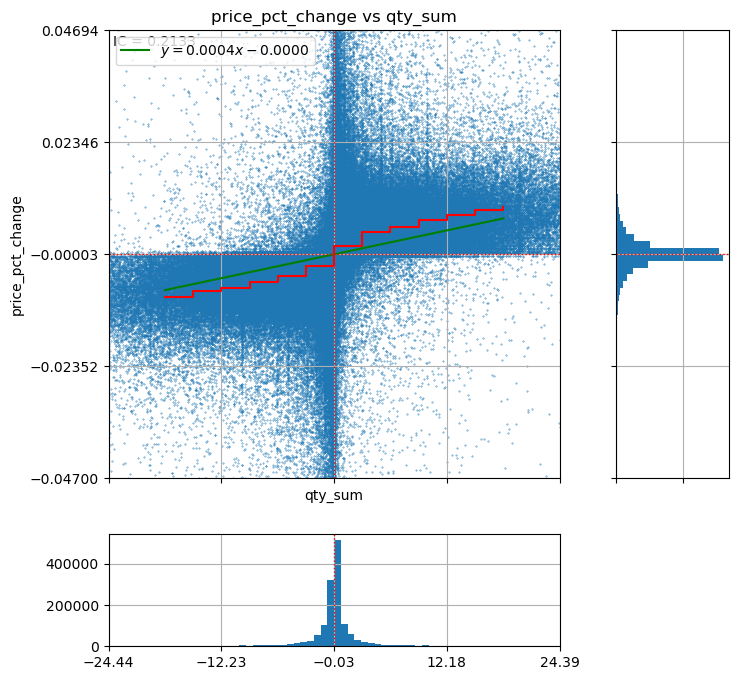

In [61]:
df_groupby = df_trades.groupby("timestamp").agg([pl.col("price").first().alias("open"), pl.col("price").max().alias("high"), pl.col("price").min().alias("low"),pl.col("price").last().alias("close"), pl.col("qty").sum().alias("qty_sum")])
df_groupby = df_groupby.with_columns([((pl.col("close") - pl.col("open")) / pl.col("open")).alias("price_pct_change")])
df_groupby = df_groupby.filter(pl.col("price_pct_change").abs() > 0)
x = df_groupby["qty_sum"]
y = df_groupby["price_pct_change"] * 100

show_correlation(x, y, title="price_pct_change vs qty_sum", xaxis_label="qty_sum", yaxis_label="price_pct_change", legend_loc="upper left")

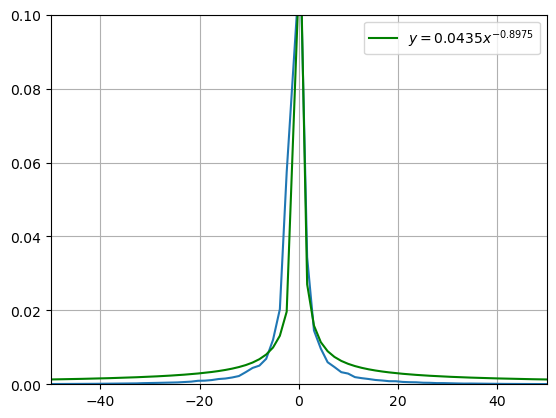

In [66]:
array_histogram = np.histogram(df_groupby["qty_sum"], bins=1024, density=True)
df_histogram = pl.DataFrame({"qty_sum": array_histogram[1][:-1], "density": array_histogram[0]}).filter(pl.col("density") > 0).filter(pl.col("density") < 0.2)

def func(x, a, b):
    return a * np.power(np.abs(x), b)
    
_popt, _pcov = curve_fit(func, df_histogram["qty_sum"], df_histogram["density"])
plt.plot(df_histogram["qty_sum"], df_histogram["density"])
plt.plot(df_histogram["qty_sum"], func(df_histogram["qty_sum"], *_popt), color = 'green', label = '$y = %s x^{%s}$' % (f'{_popt[0]:.4f}',  f'{_popt[1]:+.4f}'))

plt.ylim(0, 0.1)
plt.xlim(-50,50)
plt.grid()
plt.legend()

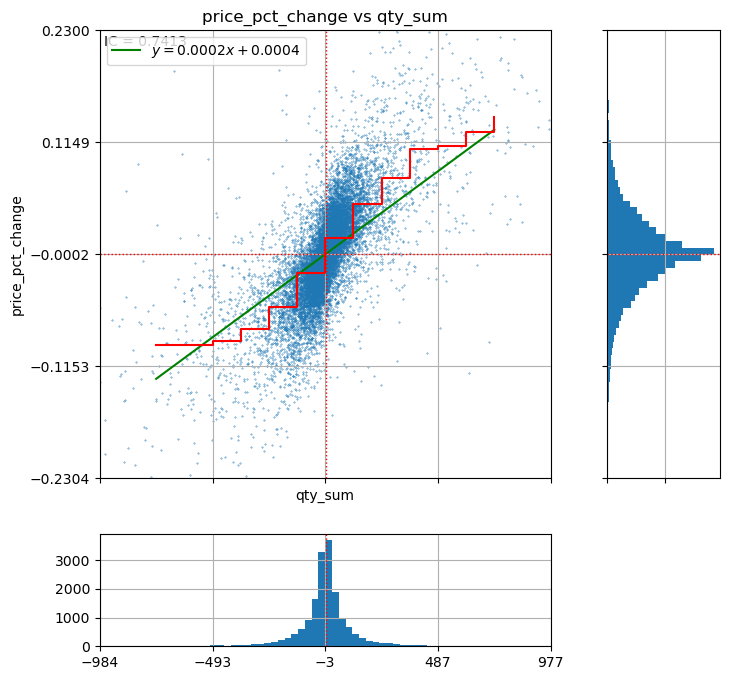

In [63]:
groupby_interval = 1* 60 * 1000

df_groupby_dynamic = df_trades.groupby_dynamic("timestamp", every=f"{int(groupby_interval)}i", closed="left").agg([pl.col("price").first().alias("open"), pl.col("price").max().alias("high"), pl.col("price").min().alias("low"),pl.col("price").last().alias("close"), pl.col("qty").sum().alias("qty_sum")])
#df_groupby_dynamic = df_trades.groupby_rolling("timestamp", period=f"{int(groupby_interval)}i", closed="left").agg([pl.col("price").first().alias("open"), pl.col("price").max().alias("high"), pl.col("price").min().alias("low"), pl.col("price").last().alias("close"), pl.col("qty").sum().alias("qty_sum")])
df_groupby_dynamic = df_groupby_dynamic.with_columns([((pl.col("close") - pl.col("open")) / pl.col("open")).alias("price_pct_change")])

x = df_groupby_dynamic["qty_sum"]
y = df_groupby_dynamic["price_pct_change"] * 100

show_correlation(x, y, title="price_pct_change vs qty_sum", xaxis_label="qty_sum", yaxis_label="price_pct_change", legend_loc="upper left")

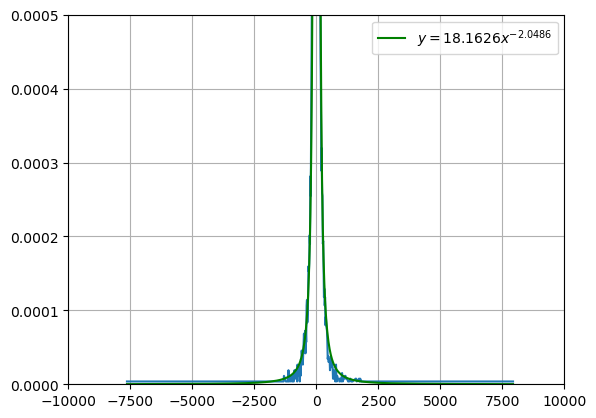

In [68]:
array_histogram = np.histogram(df_groupby_dynamic["qty_sum"], bins=1024, density=True)
df_histogram = pl.DataFrame({"qty_sum": array_histogram[1][:-1], "density": array_histogram[0]}).filter(pl.col("density") > 0).filter(pl.col("density") < 0.001)

def func(x, a, b):
    return a * np.power(np.abs(x), b)
    
_popt, _pcov = curve_fit(func, df_histogram["qty_sum"], df_histogram["density"])
plt.plot(df_histogram["qty_sum"], df_histogram["density"])
plt.plot(df_histogram["qty_sum"], func(df_histogram["qty_sum"], *_popt), color = 'green', label = '$y = %s x^{%s}$' % (f'{_popt[0]:.4f}',  f'{_popt[1]:+.4f}'))

plt.ylim(0, 0.0005)
plt.xlim(-10000,10000)
plt.grid()
plt.legend()

In [73]:
minmax_check_start = 1
minmax_check_end = 5

df_big_change = df_groupby_dynamic.filter(pl.col("price_pct_change").abs() > 0.025 / 100)
print(df_big_change.shape)
df_big_change_minmax = pl.DataFrame({"timestamp": [], "max_in_xmin": [], "min_in_xmin": []}, schema={"timestamp": pl.Int64, "max_in_xmin": pl.Float64, "min_in_xmin": pl.Float64})

for _row in tqdm(df_big_change.iter_rows()):
    _df_groupby_dynamic = df_groupby_dynamic.filter((pl.col("timestamp") >= _row[0] + groupby_interval * (1 + minmax_check_start)) & (pl.col("timestamp") < _row[0] + groupby_interval * (minmax_check_end + 1)))
    if len(_df_groupby_dynamic) == 0:
        continue
    _max = _df_groupby_dynamic.select(pl.max("high"))[0, 0] / _row[2] - 1.0
    _min = _df_groupby_dynamic.select(pl.min("low"))[0, 0] / _row[2] - 1.0


    df_big_change_minmax = df_big_change_minmax.vstack(pl.DataFrame({"timestamp": [_row[0]], "max_in_xmin": [_max], "min_in_xmin": [_min]}, schema={"timestamp": pl.Int64, "max_in_xmin": pl.Float64, "min_in_xmin": pl.Float64}))

df_big_change = df_big_change.join(df_big_change_minmax, on="timestamp", how="left").drop_nulls()

(8303, 7)


8303it [00:23, 347.53it/s] 


/tmp/ipykernel_2903007/2689620146.py:66: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


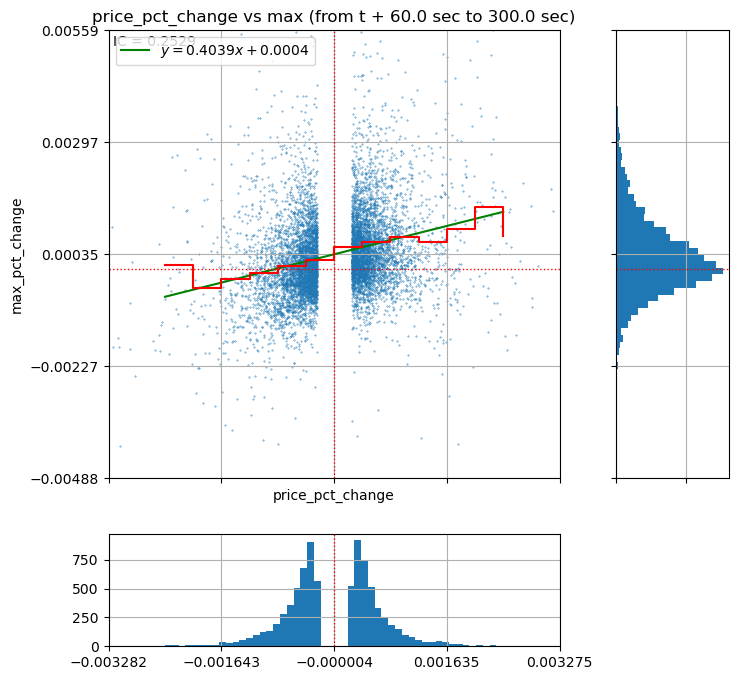

In [74]:
x = df_big_change["price_pct_change"]
y = df_big_change["max_in_xmin"]

show_correlation(x, y, title=f"price_pct_change vs max (from t + {minmax_check_start * groupby_interval / 1000} sec to {minmax_check_end * groupby_interval / 1000} sec)", xaxis_label="price_pct_change", yaxis_label="max_pct_change", legend_loc="upper left")

/tmp/ipykernel_2903007/2689620146.py:66: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


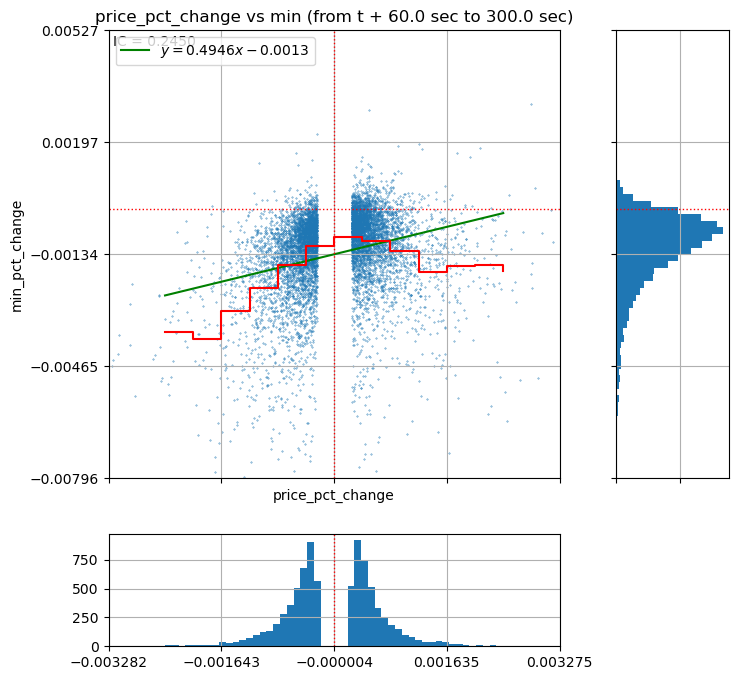

In [75]:
x = df_big_change["price_pct_change"]
y = df_big_change["min_in_xmin"]

show_correlation(x, y, title=f"price_pct_change vs min (from t + {minmax_check_start * groupby_interval / 1000} sec to {minmax_check_end * groupby_interval / 1000} sec)", xaxis_label="price_pct_change", yaxis_label="min_pct_change", legend_loc="upper left")